# Spam Detector - NLP Assignment

In [148]:
import nltk
import nltk.corpus as corpus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from nltk.metrics import ConfusionMatrix
import time

seed = 42

## Data Loading

In [149]:
path = "dataset/emails.csv"

dataset = pd.read_csv(path)

print('Dataset Size:', dataset.shape)

print("Index Column",dataset.columns[0])

print("Label Column",dataset.columns[-1])

X = dataset.drop([dataset.columns[0],dataset.columns[-1]],axis=1)
Y = dataset[dataset.columns[-1]]

Dataset Size: (5172, 3002)
Index Column Email No.
Label Column Prediction


## Preoprocessing

The dataset has been splitted in two components: **Train Set** and **Test Set**.
The train set will be used for the training the model, while the test set, only to measure the 
efficancy of the model.

I applied **shuffling** to the split to avoid ordered bias on data, and **stratification** 
so that the train and test set have the same ratio of spam and non spam emails, 
improving the vailidity of the results.

In [150]:
np.random.seed(seed)
from sklearn.model_selection import train_test_split

def dataset_split(dataset: pd.DataFrame,train_size:float|None) -> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    D = dataset[dataset.columns.drop('Email No.')]
    X = D[D.columns.drop('Prediction')]
    Y = D['Prediction']#.apply(lambda x: 'no-spam' if x == 0 else 'spam')
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=train_size,shuffle=True,stratify=Y)
    return X_train,X_test,Y_train,Y_test

train_size = 0.8

X_train,X_test,Y_train,Y_test = dataset_split(dataset=dataset,train_size=train_size)

print('Data Train Size',X_train.shape)
print('Data Test Size',X_test.shape)
print('Label Train Size',Y_train.shape)
print('Label Test Size',Y_test.shape)

Data Train Size (4137, 3000)
Data Test Size (1035, 3000)
Label Train Size (4137,)
Label Test Size (1035,)


### Stopword Dataset

I created a different dataset from the original, where I removed all the 
**english stopwords**, this to test if the there is a kind of improvement, 
to the performance, even if it is unaspected to the Naive Bayes Model.

In [151]:
stopwords = corpus.stopwords.words('english')
print("Stopwords: ",len(stopwords))
print(stopwords[:5])
inside_stopwords = X_train.columns.difference(stopwords)
X_train_stop = X_train[inside_stopwords]
X_test_stop = X_test[inside_stopwords]
print("Features: ",len(X_train_stop.columns))

Stopwords:  179
['i', 'me', 'my', 'myself', 'we']
Features:  2866


### Mutual Information Dataset

Another variation of the dataset is to remove all the words that do not bring enough 
information to the classification of the train set.

The **Mutual Information** between the single features and the labels, with the following formula:
$$
    I(\text{word},\textbf{labels}) = p(\text{word},\text{spam}) \log\left(\frac{p(\text{word},\text{spam})}{p(\text{word})p(\text{spam})}\right) +  
    p(\text{word},\text{nospam}) \log\left(\frac{p(\text{word},\text{nospam})}{p(\text{word})p(\text{nospam})}\right)
$$

After retrieving all the information value for each featuere, i discard those below a fixed threshold.

In [152]:
from sklearn.feature_selection import mutual_info_classif

mi_threshold = 0.01
mi = mutual_info_classif(X_train,Y_train)

#Vector of mutual information with index = word feature 
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

#Select the feature which have mutual information highter than the threshold

selected_words = mi_series[mi_series>mi_threshold].index

X_train_mi = X_train[selected_words]
X_test_mi = X_test[selected_words]
print("Features: ",len(X_train_mi.columns))

Features:  670


## Naive Bayes Text Classifier

In [153]:
from nltk.classify import NaiveBayesClassifier
from nltk.probability import LidstoneProbDist
from nltk.metrics import ConfusionMatrix

np.random.seed(seed)

The **NLTK** library use a different data structures for input insted of matrix or dataframe.
It use the a list of dictonaries to performe training, predicting and metrics calculation.
Therefore i created some function that cast dataframe to list of dict.

In [154]:
def make_labeled_featureset(X:pd.DataFrame,Y: pd.DataFrame) -> list:
    labeled_featuresets = [
        (row[1].to_dict(), str(label)) 
        for row, label in zip(X.iterrows(), Y)
    ]
    return labeled_featuresets

def make_featureset(X: pd.DataFrame) -> list:
    featuresets = [
        row[1].to_dict() 
        for row in X.iterrows()
    ]
    return featuresets

def make_label_list(Y: pd.DataFrame) -> list:
    return [str(label) for label in Y]

### Model
The **Naive Bayes Model** classify the data using the bayes formula, the parameters are estimated in this way:
$$
    p(\text{label}) = \frac{count(\text{label})}{count(\text{allLabels})} \\ \\
    p(\text{word}|\text{label}) = \frac{count(\text{word},\text{label}) + \gamma}{count(\text{word},\text{allLabels}) + \gamma |V|}
$$
Where $V$ is the number of total words used for the training.
In this case the parameter $\mathbf{\gamma}$ can be tuned for better performance.

But the current implementation of the class `NaiveBayesClassifier` do not allows 
edit to this parameter, it take as estimator a particular instance of the above formula
(`LidstoneProbDist` object) with $\gamma=0.5$,
in this case i override the estimator using a function that return an estimator that have
fixed gamma parameter of our choise. 

In [155]:
def train_NBC(X_train:pd.DataFrame,Y_train: pd.DataFrame,gamma:float) -> NaiveBayesClassifier:
    XY_train = make_labeled_featureset(X_train,Y_train)
    #override of the estimator with gamma of our choise
    prob_estimator = lambda freqdist, bins=None : LidstoneProbDist(freqdist,gamma,bins)
    nbc = NaiveBayesClassifier.train(XY_train,estimator=prob_estimator)
    return nbc

In [156]:
def classify_NBC(X_test:pd.DataFrame,nbc:NaiveBayesClassifier) -> list:
    X_test = make_featureset(X_test)
    return nbc.classify_many(X_test)

### Cross Validation e Fine Tuning

To tune the model on the best $\gamma$ parameter, I use the the **K-Fold Cross Validation** method, 
which mean that the training set will be splitted in $k$ segments, and the model will be trained 
$k$ times on the $k-1$ segments, and the $k$th will be used as test set.

For the evaluation will be used the mean **f1-score** of all $k$ execution, for each $\gamma$ in input.

In [157]:
from sklearn.model_selection import StratifiedKFold

def cross_validation_fine_tuning(X_train:pd.DataFrame,Y_train:pd.DataFrame,Gammas,n_split:int,verbose:bool=False) -> dict:

    list_measures = {gamma: [] for gamma in Gammas}
    mean_measures = {}

    for gamma in Gammas:

        skf = StratifiedKFold(n_splits=n_split,shuffle=True)
        skf.get_n_splits(X_train,Y_train)
        k_folds = skf.split(X_train,Y_train)

        # k_fold containt a list of indexes that will rappresent the kth-fold for test, 
        # and the others will be use for training.
        for j,(train_index, val_index) in enumerate(k_folds):
            X_train_k = X_train.iloc[train_index]
            Y_train_k = Y_train.iloc[train_index]
            X_val_k = X_train.iloc[val_index]
            Y_val_k = Y_train.iloc[val_index]

            nbc = train_NBC(X_train_k,Y_train_k,gamma)

            Y_pred = classify_NBC(X_val_k,nbc)

            Y_pred = [int(label) for label in Y_pred]

            score = f1_score(Y_pred,Y_val_k)
            
            if (verbose):
                print(f"Gamma {gamma} on {j}-fold: {score}")
            list_measures[gamma].append(score)
        
        mean_measures[gamma] = np.mean(list_measures[gamma])
    return mean_measures

In [158]:
#simply retrive the gamma assosieted with the highest mean f1 score on the k executions
def get_best_gamma(eval_measures:dict) -> int:
    best_gamma = max(eval_measures,key=eval_measures.get)
    print("Best Gamma: ",best_gamma)
    print("Mean F1: ",eval_measures[best_gamma])
    return best_gamma

### Evaluation

For the final evaluation after choose the best $\gamma$, will be used 
the **Confusion Matrix** of NLTK. 

In [159]:
def eval_model(X_test:pd.DataFrame,Y_test:pd.DataFrame,nbc:NaiveBayesClassifier) -> ConfusionMatrix:
    Y_test = make_label_list(Y_test)
    Y_pred = classify_NBC(X_test,nbc)
    return ConfusionMatrix(Y_pred,Y_test)

### Gamma Parameters

Usually the parameter $\gamma$ range from $0$ to $1$, after a first search
in that range, I locateted that the best parameter is **lower** than $0.25$,
so i performed a fine tuning of $\gamma$ in range $(0,0.25)$.

In [160]:
Gammas = [0,0.05,0.10,0.15,0.20,0.25]

### Complete Dataset

In [161]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_complete = train_NBC(X_train,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_complete = eval_model(X_test,Y_test,nbc_complete)
end_predict = time.time()

print(cs_complete.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  228.67818999290466  seconds
Best Gamma:  0.05
Mean F1:  0.802905374411449
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.8990 | 0.9210
  1 | 0.7400 | 0.8441 | 0.7886

Training Time:  6.49997091293335  seconds
Classification Time:  2.9500598907470703  seconds


### Stopwords Dataset

In [162]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train_stop,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_stop = train_NBC(X_train_stop,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_stop = eval_model(X_test_stop,Y_test,nbc_stop)
end_predict = time.time()

print(cs_stop.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  219.88942885398865  seconds
Best Gamma:  0.05
Mean F1:  0.8026579917887823
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.8978 | 0.9204
  1 | 0.7367 | 0.8435 | 0.7865

Training Time:  6.251708745956421  seconds
Classification Time:  2.666918992996216  seconds


### Dataset with Mutual Information

In [163]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train_mi,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_mi = train_NBC(X_train_mi,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_mi = eval_model(X_test_mi,Y_test,nbc_mi)
end_predict = time.time()

print(cs_mi.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  49.497872829437256  seconds
Best Gamma:  0.05
Mean F1:  0.8267710652323135
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.9144 | 0.9290
  1 | 0.7833 | 0.8514 | 0.8160

Training Time:  1.3634083271026611  seconds
Classification Time:  0.6159384250640869  seconds


### Summary
Apparently the best gamma for all the dataset is $\gamma=0.05$ 
and the dataset reduced using **mutual information selection**, perform better in classification.
We can also observe, what words weigth more in the classification procedure.

In [164]:
print("Dataset Complete:")
nbc_complete.show_most_informative_features()

Dataset Complete:
Most Informative Features
               forwarded = 1                   0 : 1      =    214.9 : 1.0
                     sex = 1                   1 : 0      =    167.9 : 1.0
                     biz = 1                   1 : 0      =    116.6 : 1.0
                      rx = 1                   1 : 0      =    112.0 : 1.0
                     hpl = 1                   0 : 1      =    109.0 : 1.0
                    spam = 1                   1 : 0      =    100.3 : 1.0
                  weight = 1                   1 : 0      =     98.0 : 1.0
                     iit = 1                   1 : 0      =     88.7 : 1.0
                   cheap = 1                   1 : 0      =     81.2 : 1.0
                   sleep = 1                   1 : 0      =     79.4 : 1.0


In [165]:
print("Dataset StopWord:")
nbc_stop.show_most_informative_features()

Dataset StopWord:
Most Informative Features
               forwarded = 1                   0 : 1      =    214.9 : 1.0
                     sex = 1                   1 : 0      =    167.9 : 1.0
                     biz = 1                   1 : 0      =    116.6 : 1.0
                      rx = 1                   1 : 0      =    112.0 : 1.0
                     hpl = 1                   0 : 1      =    109.0 : 1.0
                    spam = 1                   1 : 0      =    100.3 : 1.0
                  weight = 1                   1 : 0      =     98.0 : 1.0
                     iit = 1                   1 : 0      =     88.7 : 1.0
                   cheap = 1                   1 : 0      =     81.2 : 1.0
                   sleep = 1                   1 : 0      =     79.4 : 1.0


In [166]:
print("Dataset Mutual Information:")
nbc_mi.show_most_informative_features()

Dataset Mutual Information:
Most Informative Features
               forwarded = 1                   0 : 1      =    214.9 : 1.0
                     sex = 1                   1 : 0      =    167.9 : 1.0
                     biz = 1                   1 : 0      =    116.6 : 1.0
                      rx = 1                   1 : 0      =    112.0 : 1.0
                     hpl = 1                   0 : 1      =    109.0 : 1.0
                  weight = 1                   1 : 0      =     98.0 : 1.0
                     iit = 1                   1 : 0      =     88.7 : 1.0
                   cheap = 1                   1 : 0      =     81.2 : 1.0
             legislation = 1                   1 : 0      =     72.4 : 1.0
                    duty = 2                   1 : 0      =     65.4 : 1.0


In this case the most relevant words are `forwarded`, `sex` and `biz`, in particular 
-  `forwarded` is associeted to **non-spam** email with a ratio 215 to 1
-  `sex` is associeted to **spam** email with a ratio 168 to 1
-  `biz` is associeted to **spam** email with a ratio 116 to 1

Also these words, have more weigth in the mutual information dataset, since most of the 
other words, are been excludeted since they bring low information.
This dataset perform better and it significantly fasten the train and prediction of the model.

If we filter this lists, it is possible to create spam or not-spam lists.

## Multi-layer Perceptrone - 2 Layers

Naive Bayes model, assumes that there is indipendence between the words, 
it is a bit unlikely, even if the result reached are good, we can do better.

The next model i want to try is the **MLP with 2 layers**, which is a fully-connected neural network.

### Cross Validation e Fine Tuning

The model is initialized with the following fixed parameters:
- `adam`: which is the solver that performs the gradient descent for parameters optimization
- `shuffle`: which shuffles the samples at each epoch before dividing them into batches 
- `early_stopping`: which interrupts the training loop if there is not any improvement over the evaluation of the trained model on the validation set.
- `relu`: the activation function that will be used between the layers which is difined by:
$$
\text{ReLU}(x)= \begin{cases} 
                    x & \text{if } x > 0 \\ 
                    0 & \text{if } x \leq 0 
                \end{cases}
$$

While the tuning will be performed on the following parameters:
- `alpha`: which is the regularization parameter used with the loss function in order to smooth the 
optimization done by adam
- `hidden_layer_sizes`: it is possible for a small model to do not capture the pattern of the dataset, while a large model can easly overfit for this kind of task

In [167]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier


np.random.seed(seed)

param_grid = {
    'hidden_layer_sizes': [(70,70),(80,80),(90,90)],
    'activation' : ['relu'],
    'solver': ['adam'],
    'alpha': [1e-5,1e-6,1e-7],
    'shuffle': [True],
    'early_stopping': [True]
}

# grid search cv will perform stratified k-fold crossvalidation for each 
# combination of parameter indicated in param_grid, than wil select the best model 
# using the mean f1-score of the k trainings.
best_mlpc_model = GridSearchCV(MLPClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))
best_mlpc_model.fit(X_train_mi,Y_train)

print(best_mlpc_model.best_params_)

{'activation': 'relu', 'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (80, 80), 'shuffle': True, 'solver': 'adam'}


### Build-In Model with NLTK

It is possible to use classification model of sklearn in combination with **NLTK**, so that 
we can match the dictionary input of NLTK models with the arraylike input of sklearn.

In [19]:
from nltk.classify import SklearnClassifier

clf = SklearnClassifier(best_mlpc_model)

train_labeled_featuresets = make_labeled_featureset(X_train,Y_train)
test_featuresets = make_featureset(X_test)
test_labels = make_label_list(Y_test)

start_train = time.time()
clf.train(train_labeled_featuresets)
end_train = time.time()

start_predict = time.time()
pred_labels = clf.classify_many(test_featuresets)
end_predict = time.time()

cs = ConfusionMatrix(pred_labels,test_labels)
print(cs.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9864 | 0.9959 | 0.9911
  1 | 0.9900 | 0.9674 | 0.9786

Training Time:  559.3927063941956  seconds
Classification Time:  1.1136808395385742  seconds


### Mutual Information Dataset
Using the MLP on the MI-dataset will performe good but worse respect to the complete dataset, 
that becouse feature selection is performed by the neural network, 
using a small feature dataset will remove only significance.

In [168]:
from nltk.classify import SklearnClassifier

clf = SklearnClassifier(best_mlpc_model)

train_labeled_featuresets = make_labeled_featureset(X_train_mi,Y_train)
test_featuresets = make_featureset(X_test_mi)
test_labels = make_label_list(Y_test)

start_train = time.time()
clf.train(train_labeled_featuresets)
end_train = time.time()

start_predict = time.time()
pred_labels = clf.classify_many(test_featuresets)
end_predict = time.time()

cs = ConfusionMatrix(pred_labels,test_labels)
print(cs.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9823 | 0.9770 | 0.9796
  1 | 0.9433 | 0.9561 | 0.9497

Training Time:  179.94856762886047  seconds
Classification Time:  0.28311920166015625  seconds


## Provenance Analysis
While the first part is centered on the *content* of the email, in this part I'll analyze the 
**provenance**.

It is hard to retrive the provanence based only on the word counts; I tried to resemble provenence with **clustering**.

### Dimentional Reduction
Before performe clustering, it is important **reduce the dimention** of the feature in such way to plot it, to see it is a feasable task to do it or it is too sparse. In this case I choose to reduce the dimetion from 3000 words to 2 components (that do not rappresent the most relevant words).

Also to obtain a good reduction is crucial to **scale** the data, in this way, they will have the same unit measure.

I used two non-linear dimentional reduction methods to do so, that becouse the dataset it self is highly sparse and 
not much linerity.
While the choise of the ``StandardScaler`` is arbitry, this experiment performe well also with ``MinMaxScaler``.

In [169]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

np.random.seed(seed)

dimention = 2

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled.shape)

(4137, 3000)


In [170]:
# function that generate a list of colors based on spam or not-spam
def get_spam_color(Y):
    return ['green' if label == 0 else 'orange' for label in Y]

In [171]:
def plot_components(X,colors):
    plt.scatter(X[:, 0], X[:, 1],c=colors,s=15)
    plt.show()

### Kernel PCA
The idea behind this method is to buld a matrix which elements are composed by the evaluation of the **kernel** function on each pair of data. And than use the **Principal Component Analysis** to performe the reduction.

Apparently the **sigmoidal** kernel procuce a clear differentiation between spam (*orange*) and no-spam (*green*), 
so we can say that if the data is in low region is highly probable that it comes from a spam domain.

I want to highligh that the dimentional reduction is performed only train data and it base on them, and apply it on new data, without the need to reperform the reduction.

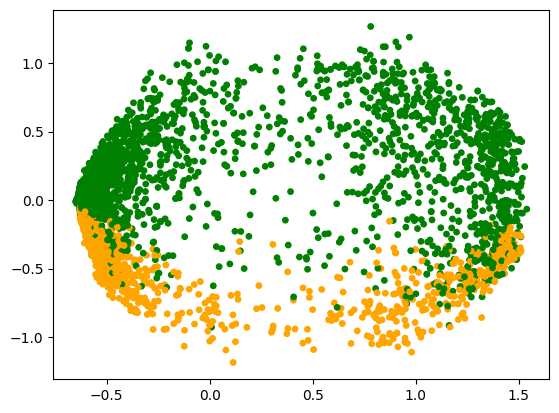

In [172]:
kpca = KernelPCA(n_components=dimention,kernel='sigmoid',gamma=1)

X_train_kpca = kpca.fit_transform(X_train_scaled)

plot_components(X_train_kpca,get_spam_color(Y_train))

#### Model and Cross-Validation

One model of the best models to classify cloud of point is the **K-Nearest Neighbors** model. 
I performed the usual fine tuning to find the best parameters between:
- number of neighbors to use for classigication
- metric to measure the distance between the point
- if to weights the points based on the distance or not (uniform)  

In [193]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

np.random.seed(seed)

param_grid = {
    'n_neighbors' : np.arange(1,9,2),
    'weights':['uniform','distance'],
    'metric': ['euclidean','haversine','manhattan']
}
 
best_knn_model = GridSearchCV(KNeighborsClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))

best_knn_model.fit(X_train_kpca,Y_train)

print(best_knn_model.best_params_)

{'metric': 'euclidean', 'n_neighbors': np.int64(7), 'weights': 'uniform'}


#### Evaluation
The methods perform better than Naive Bayes and it is significanly faster.

In [195]:
X_test_kpca = kpca.transform(scaler.transform(X_test))
Y_pred = best_knn_model.predict(X_test_kpca)

cs = ConfusionMatrix(make_label_list(Y_pred),make_label_list(Y_test))
print(cs.evaluate())

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9333 | 0.9772 | 0.9548
  1 | 0.9467 | 0.8529 | 0.8973



### T-SNE
The **T-sne** method is more complex, in few words, it measure the probability of being close between the original pair of point and the reduced pair of point, using a mapping. 
Maximizing this probability we obtain the best mapping to the lower space.

In this case, it is not possible to apply the reduction to train and test set separately, so I used the entire dataset, and then resplitted.

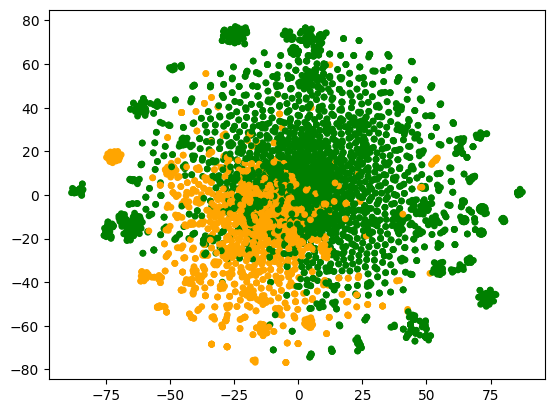

In [175]:
from sklearn.model_selection import train_test_split
np.random.seed(seed)
tsne = TSNE(n_components=dimention)

X_tsne = tsne.fit_transform(scaler.fit_transform(X))

plot_components(X_tsne,get_spam_color(Y))

X_train_tsne, X_test_tsne, Y_train_tsne , Y_test_tsne = train_test_split(X_tsne,Y,train_size=train_size,shuffle=True,stratify=Y)


#### Model and Cross-Validation 

In [197]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

np.random.seed(seed)

param_grid = {
    'n_neighbors' : np.arange(1,9,2),
    'weights':['uniform','distance'],
    'metric': ['euclidean','haversine','manhattan']
}
 
best_knn_model = GridSearchCV(KNeighborsClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))

best_knn_model.fit(X_train_tsne,Y_train_tsne)

print(best_knn_model.best_params_)

{'metric': 'euclidean', 'n_neighbors': np.int64(5), 'weights': 'distance'}


#### Evaluation

The performance are similar to the KPCA method, but I noticed that this method, generates a sort fo blobs around the main cluster, in the next section I tried to analize those clusters, in order to find moder about the provence.

In [198]:
np.random.seed(seed)
Y_pred = best_knn_model.predict(X_test_tsne)
cs = ConfusionMatrix(make_label_list(Y_pred),make_label_list(Y_test_tsne))
print(cs.evaluate())

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9374 | 0.9636 | 0.9503
  1 | 0.9133 | 0.8562 | 0.8839



## Clustering

First, I used **HDBSCAN** for clustering, an instance of **DBSCAN** algorithm which is based on the density of points, in such way to obtain two type of points:
- Cluster Point (colored points)
- Noise Point (noise points)

In this case I setted that the algorithm will create clusters with size between 30 and 200, in this way, will avoid too big clusters with few relation between the points, and too small clusters, which increase the number of cluster to analyze.

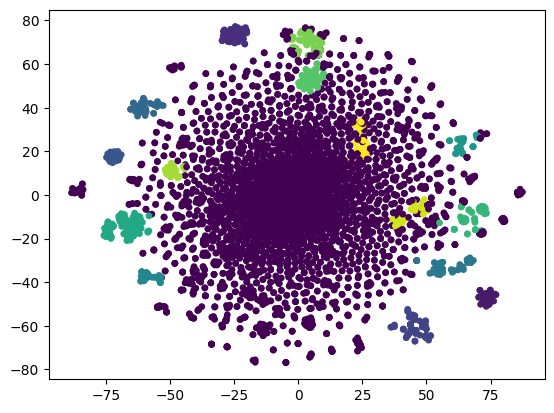

In [178]:
from sklearn.cluster import HDBSCAN
np.random.seed(seed)
hdbscan = HDBSCAN(min_cluster_size=30,max_cluster_size=200)

clusters = hdbscan.fit_predict(X_tsne)

plot_components(X_tsne,clusters)

### Cluster Selection

Then I removed the noise cluster, which is hard to analyse since it contains both spam and not-spam emails.
I also plotted type of cluster (spam or not-spam) in this case is possible that the single clusters, containts emails from one person or domain, and discuss on a certain topic.

Number of separeted data: 964 of 5172


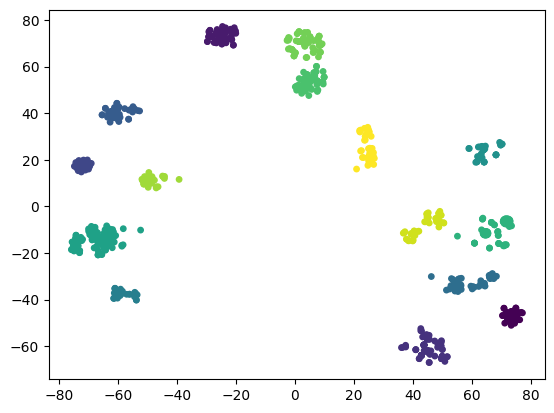

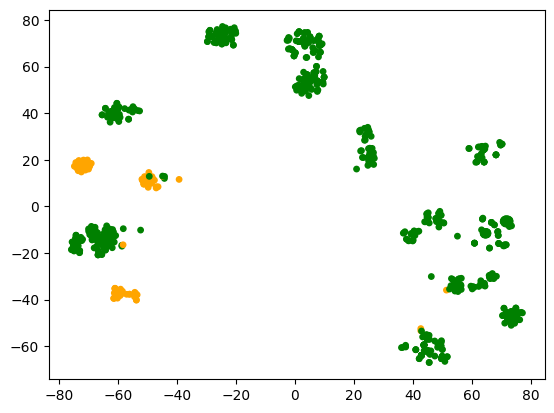

In [179]:
selected_clusters_index = clusters!=clusters[0]
print(f"Number of separeted data: {len(clusters[selected_clusters_index])} of {X_tsne.shape[0]}")
plot_components(X_tsne[selected_clusters_index],clusters[selected_clusters_index])
plot_components(X_tsne[selected_clusters_index],get_spam_color(Y[selected_clusters_index]))

### Cluster Analysis

In the end I analized the clusters, plotting the mean count of common words after choosing:
- Most significant words to classify spam or not-spam (with mutual information)
- Removing the stopwords
- Removing too short words, those are probably part of html fragments or typos.

In this way it is possible to obtain some information on the topic of the clustered emails.

In [199]:
def analyze_cluster(cluster_number):
    selected_clusters_index = clusters==cluster_number
    print(f"Number of separeted data: {len(clusters[selected_clusters_index])} of {X_tsne.shape[0]}")
    plot_components(X_tsne,selected_clusters_index)
    emails = X.iloc[selected_clusters_index]
    emails = emails[selected_words]
    emails = emails[emails.columns.difference(stopwords)]
    emails = emails[[word for word in emails.columns if len(word)>3]]
    total_word_counts = emails.mean(axis=0).sort_values(ascending=False)
    print('Common Words:')
    print(total_word_counts[:10])

Cluster 3 is a spam cluster, and contains words like *computrons*,*free*,*deal* and *link*, probably 
the topic is the purchase of the toy model computron.

<img src="https://i.redd.it/lzpctikx23591.jpg" width="200">

Number of separeted data: 41 of 5172


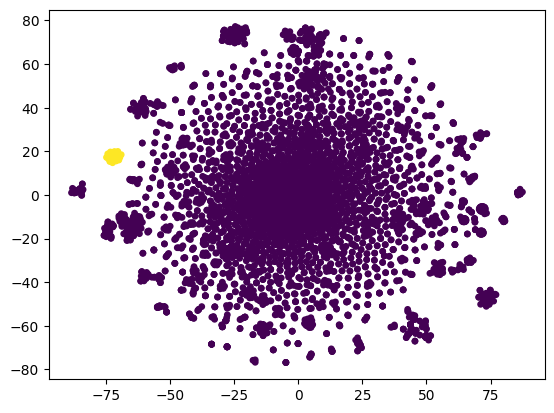

Common Words:
computron    5.902439
contact      3.951220
mail         3.317073
move         3.024390
remove       3.000000
deal         2.926829
please       2.560976
lease        2.560976
link         2.268293
free         2.170732
dtype: float64


In [200]:
analyze_cluster(cluster_number=3)

Cluster 3 is a non-spam cluster, and contains words like *enron*,*corp*,*energy*, probably 
the topic is about the Enron Corporation an energy multinational company.

<img src="https://upload.wikimedia.org/wikipedia/it/thumb/5/52/Enron.jpg/295px-Enron.jpg" width="200">

Also the words *forward* and *forwarded* are present, according to the importance words, highlited by the Naive Classifier, those 
words are an high idexes of not-spam emails.

Number of separeted data: 74 of 5172


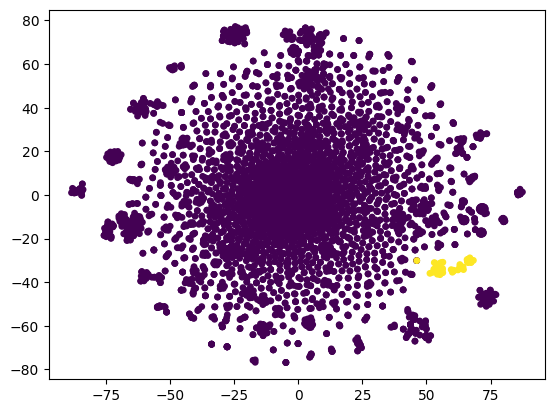

Common Words:
enron        2.256757
corp         1.337838
energy       1.175676
ward         1.094595
forward      1.094595
subject      1.067568
forwarded    1.040541
attached     1.027027
noms         0.770270
change       0.594595
dtype: float64


In [203]:
analyze_cluster(cluster_number=5)